In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [4]:
from keras.layers import LSTM

In [7]:
movie_reviews = pd.read_csv("/content/drive/My Drive/imdb/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [8]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

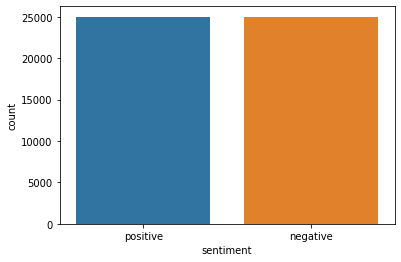

In [10]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [11]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [12]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [13]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))


In [14]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [15]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/imdb/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [21]:
model = keras.Sequential([
                    keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False),
                    keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
                    keras.layers.GlobalMaxPool1D(),
                    keras.layers.Dense(20, activation='relu'),
                    keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 9,494,357
Trainable params: 239,657
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [23]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 6s 24ms/step - loss: 0.5571 - acc: 0.6990 - val_loss: 0.4198 - val_acc: 0.8033
Epoch 2/6
250/250 [==============================] - 5s 21ms/step - loss: 0.4007 - acc: 0.8183 - val_loss: 0.3717 - val_acc: 0.8334
Epoch 3/6
250/250 [==============================] - 5s 21ms/step - loss: 0.3574 - acc: 0.8405 - val_loss: 0.3489 - val_acc: 0.8493
Epoch 4/6
250/250 [==============================] - 5s 21ms/step - loss: 0.3208 - acc: 0.8608 - val_loss: 0.3668 - val_acc: 0.8319
Epoch 5/6
250/250 [==============================] - 5s 21ms/step - loss: 0.2942 - acc: 0.8742 - val_loss: 0.3204 - val_acc: 0.8566
Epoch 6/6
250/250 [==============================] - 5s 21ms/step - loss: 0.2605 - acc: 0.8902 - val_loss: 0.3104 - val_acc: 0.8646


In [24]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.3075 - acc: 0.8673


In [25]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.30749499797821045
Test Accuracy: 0.8672999739646912


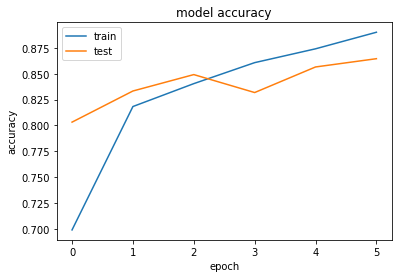

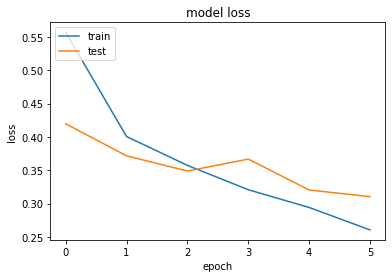

In [26]:

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [27]:
n = 500

In [28]:
instance = X[n] 
output = y[n]
print(instance)
# print(output)
#1,10

What an empty and lack lustre rendition of the classic novel do wish people would stop messing about with classics when they clearly have no idea of the real intention or point of the original This version is no different felt that the Ralph Fiennes version is much worse though as the casting of Juliette brioche as Kathy has got to be the worst casting decision EVER anyway back to this version It aims to make the story relevant to contemporary setting and in musical style It succeeds in both but high art it is nit Throwaway viewing for rainy day maybe The direction was average and the editing abysmal Worse than the old Quincy Deepak Verma does great turn as Hindley and is in fact one of Britains wasted talents The part of Heath was played with great charm and belief and think that the casting is the strongest point of this project Although more talented director would have made better use of the facilities he had Its clear that he was director for hire and didn instill the project with

In [29]:


instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

prediction = model.predict(instance)


if prediction<0.5:
  sentiment = "Negative"
else:
 sentiment = "Positive"

print("Model prediction: ", sentiment)

actual = "Positive" if sentiment =="Positive" else "Negative"
print("Actual Label:", actual)


Model prediction:  Positive
Actual Label: Positive


In [30]:
model.save('/content/drive/MyDrive/imdb')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/imdb/assets
